In [1]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.

       Prints the result to stdout and returns the exit status.
       Provides a printed warning on non-zero exit status unless `warn`
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2024-winter/lab2-5.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Course 236299

## Lab 2-5 – A single-layered Transformer

In the previous lab, you explored the **attention mechanism**, a crucial building block that enables models to dynamically focus on different parts of the input sequence. This marked a significant shift from traditional sequence models like n-grams and RNNs, which struggled with fixed context windows or vanishing gradients. By incorporating attention, we started to unlock the power of flexible, long-range context modeling.

However, attention alone is not enough to fully capture the complexity of modern language models. In this lab, we will take the next step toward understanding the **Transformer** architecture by introducing several key components that, when combined with attention, form the backbone of this state-of-the-art model:

1. **Positional Encoding:** Unlike RNNs, which inherently process input in sequence, the attention mechanism is inherently order-agnostic. (In fact, it's this property of attention that allows parallel implementation.) To give the model a sense of word order, we will add positional embeddings to the token embeddings, allowing the Transformer to account for sequence order during processing.
2. **Multi-Layer Perceptrons (MLPs):** After attention has been applied, the output is passed through feed-forward neural networks. These MLPs, applied independently to each position, help the model process more complex representations of the input.
3. **Normalization:** To improve training stability, we will introduce layer normalization, which ensures that the distribution of inputs to each layer remains balanced.
4. **Residual Connections:** Finally, we will add residual connections, a technique that allows information to bypass certain layers. This enables the model to retain important information from earlier layers and helps mitigate the risk of gradient degradation during backpropagation.
   
By the end of this lab, you will have made use of all these components, which together form the foundation of the Transformer architecture. The Transformer model, through its parallelizable and scalable nature, has revolutionized fields like natural-language modeling, making it a central topic in modern deep learning.

# Preparation – Loading packages and data

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

In [3]:
import json
import math
import random
import wget
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from math import inf
from tokenizers import Tokenizer
from transformers import PreTrainedTokenizerFast

from tqdm.auto import tqdm

In [4]:
# Set random seeds
SEED = 1234
torch.manual_seed(SEED)
random.seed(SEED)

# GPU check, sets runtime type to "GPU" where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Again, we use the *Federalist* papers.

In [5]:
# Prepare to download needed data
def download_if_needed(source, dest, filename):
    print(f"./{dest}{filename}")
    if os.path.exists(f"./{dest}{filename}"):
        print (f"Skipping {filename}")
    else:
        print (f"Downloading {filename} from {source}")
        wget.download(source + filename, out=dest)

source_path = "https://github.com/nlp-236299/data/raw/refs/heads/master/Federalist/"
data_path = "data/"

os.makedirs(data_path, exist_ok=True)
# Download files, including pretrained language models
for filename in ["federalist_data_raw2.json",
                 "tokenizer.pt",
                 # language models:
                 # Hamilton          Madison
                 "transformer_lm_h.pt",   "transformer_lm_m.pt", # transformer
                ]:
    download_if_needed(source_path, data_path, filename)

# Read in the raw data
dataset = json.load(open(data_path + "federalist_data_raw2.json"))

# Read in the pretrained tokenizer
hf_tokenizer = torch.load(data_path + "tokenizer.pt")
hf_tokenizer.split_special_tokens = False
hf_tokenizer.pad_token_id = 1

./data/federalist_data_raw2.json
./data/tokenizer.pt
./data/transformer_lm_h.pt
./data/transformer_lm_m.pt


<ipython-input-5-a7ef7a718c83>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hf_tokenizer = torch.load(data_path + "tokenizer.pt")


Once again we will split the dataset into training, validation, and test sets, but we won't be using the training set in this lab.

Again, for the validation set, we have separate ones for papers authored by Hamilton (`validation_hamilton`) and papers authored by Madison (`validation_madison`).

In [6]:
# Split training, validation, and test sets
TRAIN_RATIO = 0.9
# Extract the papers of unknown authorship
testing = list(filter(lambda ex: ex['authors'] == 'Hamilton or Madison',
                      dataset))
# Change gold labels in-place
for ex in testing:
    ex['authors'] = 'Madison'

# Extract the papers by Madison
dataset_madison = list(filter(lambda ex: ex['authors']=='Madison', dataset))
random.seed(SEED)
random.shuffle(dataset_madison)
training_size_madison = int(math.floor(TRAIN_RATIO * len(dataset_madison)))
validation_madison = dataset_madison[training_size_madison:]

# Extract the papers by Hamilton
dataset_hamilton = list(filter(lambda ex: ex['authors']=='Hamilton', dataset))
random.seed(SEED)
random.shuffle(dataset_hamilton)
training_size_hamilton = int(math.floor(TRAIN_RATIO * len(dataset_hamilton)))
validation_hamilton = dataset_hamilton[training_size_hamilton:]

# We only consider the first 200 tokens of each document for speed
def truncate(s, k=200):
    for document in s:
        document['tokens'] = document['tokens'][:k]
truncate(validation_madison)
truncate(validation_hamilton)
truncate(testing)

print (f"Madison validation size:  {len(validation_madison)} documents\n"
       f"Hamilton validation size: {len(validation_hamilton)} documents")

Madison validation size:  3 documents
Hamilton validation size: 6 documents


# Issues of order in attention

In the last lab, you implemented _attention_, and used it as a basis for a language model. The attention model improves on the RNN by allowing the output to be sensitive to the prior context in a much more expansive way. Whereas the RNN encapsulates all information about the prior context in a single fixed-size history vector, attention allows prior context to be calculated with access to the entire prior context as a weighted average of values associated with each prior token. In equations, the RNN sets

$$
\vect{h}_t = \vect{W}\vect{h}_{t-1} + \vect{V}\vect{x}_t\\
$$

(depending only on $\vect{h}_{t-1}$ to provide contextual information), whereas the attention model sets

$$
\vect{h}_t = \operatorname{attn}(\vect{q}_t, \vect{k}_{1:t}, \vect{v}_{1:t})
$$

(which depends on the $\vect{k}$ and $\vect{v}$ values for _all_ of the preceding time steps).

<!-- BEGIN QUESTION -->

---

**Question:** Given this difference, what is the complexity of the output computations of RNN and attention as a function of the length $T$ of its input $x_{1:t}$? Which has worse complexity? You can give your answer using big-O notation.
<!--
BEGIN QUESTION
name: open_response_complexity
manual: true
-->

The transformer model has a worse complexity compared with the RNN model.

For the RNN model:
In each iteration we calculate a hidden and output vectors based on a single current token and a *single* prev hidden layer (which represents all prev tokens). This means that for a single token we make $O(1)$ calculations, so for overall t tokens we get $O(t)$ calculations.

For the transformer model:
The attention we calculate for each single token is based on all other tokens (ignoring the masking for simplicity, this doesnt affect the final answer, we made sure with the TA in class :). This means that for a single token we make $O(t)$ calculations. Overall for t tokens we get $O(t*t)=O(t^2)$ calculations.

<!-- END QUESTION -->



## Attention is order-independent

Notice that the attention calculation is insensitive to permutations of context tokens. Imagine we permute some of the tokens in the context of an attention calculation. The attention calculation computes a weighted average of the $\vect{v}_i$ with the weights based on the corresponding $\vect{k}_i$. If we permute the context tokens, we permute the $\vect{v}_i, \vect{k}_i$ pairs, but the weighted average is not affected.

This position independence has the nice property that the attention values at each time step ($\vect{h}_t$) can be calculated independently, and therefore in parallel, for a tremendous efficiency advantage over RNNs, which can calculate $\vect{h}_t$ only after $\vect{h}_{t-1}$ has been calculated, that is, sequentially.

On the other hand, this position independence has the unfortunate property that the attention values are _independent of word order_. Of course, natural language is highly dependent on word order. (Recall Charles Anderson Dana's observation about "man bites dog" and "dog bites man".) This is the first problem with attention that the Transformer model mitigates using _positional embeddings_.

## Positional embeddings to the rescue

The order-independence of attention is typically resolved by encoding at each step not only an embedding for the token but also an embedding for the absolute position of that token. There have been many proposals for this _positional embedding_. We use a fixed embedding based on trigonometric functions as proposed in the seminal Transformers paper "[Attention is all you need](https://arxiv.org/pdf/1706.03762)".
The positional embedding for time step $t$ is a vector of $D$ elements, each of which is defined to be the value of a sinusoidal function (either sine or cosine) at a phase determined by the element's index. Formally, it is something like

$$ \operatorname{pe}(t, i) = \left\{
     \begin{array}{ll}
       \sin(t / 10^{4i/D}) & \mbox{if $i$ is even} \\
       \cos(t / 10^{4(i-1)/D}) & \mbox{if $i$ is odd}
     \end{array}
     \right.
$$

where $t$ is the time step and $i$ is the index within the embedding vector.

> The magic numbers 10 and 4 and the division by $D$ are empirically determined.

The positional embedding may be concatenated with the input embedding or (as we do here) simply added.

## Visualizing positional embeddings

The intuition behind this sinusoidal positional embedding is that the values of the sinusoidal waves sampled at the different wavelengths provide information about where we are in the sequence of time steps. The visualization below depicts the positional embeddings for different positions as rows in a heat map.

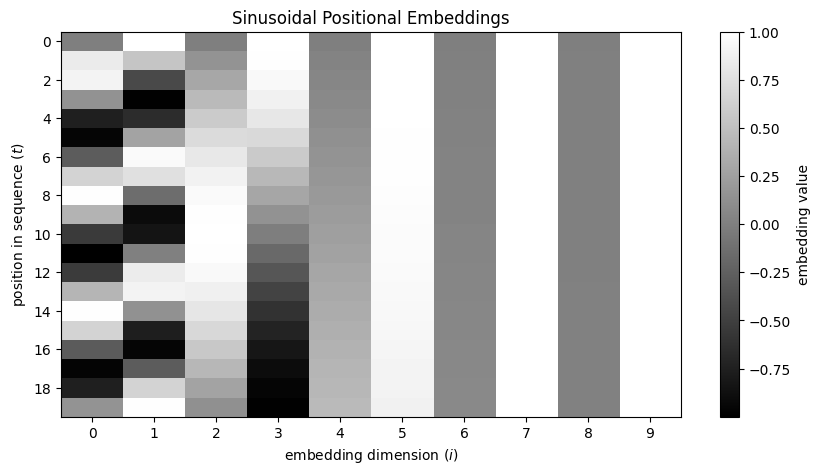

In [7]:
def get_positional_embeddings(seq_length, D):
    """
    Returns samples from a positional embedding

    Arguments:
        seq_length: number of time steps in the sequence
        D: size of the embedding dimension
    Returns:
        positional_embeddings: An array of seq_length elements,
        each an array of D elements from the embedding
    """
    positions = np.arange(seq_length)[:, np.newaxis]  # shape (seq_length, 1)
    dimensions = np.arange(D)[np.newaxis, :]  # shape (1, d_model)

    # Compute angle rates using the formula from the "Attention Is All You Need" paper
    angle_rates = 1 / np.power(10000, (2 * (dimensions // 2)) / np.float32(D))

    # Generate angle radians
    angle_rads = positions * angle_rates

    # Apply sine to even indices and cosine to odd indices
    positional_embeddings = np.zeros_like(angle_rads)
    positional_embeddings[:, 0::2] = np.sin(angle_rads[:, 0::2])
    positional_embeddings[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return positional_embeddings

# Parameters
seq_length = 20  # Length of the sequence
D = 10  # Dimensionality of the model (must be even)

# Get positional embeddings
pos_embeddings = get_positional_embeddings(seq_length, D)

# Plot the positional embeddings
plt.figure(figsize=(10, 5))
plt.title("Sinusoidal Positional Embeddings")
plt.imshow(pos_embeddings, aspect="auto", cmap="gray")
plt.colorbar(label="embedding value")
plt.xlabel("embedding dimension ($i$)")
plt.ylabel("position in sequence ($t$)")
plt.yticks(range(0,20,2))
plt.xticks(range(0,10))
None

# Uncomment the line below if the plot does not show up.
# Make sure to comment it before submitting to gradescope
# since there would be some autograder issues with plt.show().

#plt.show()

## Implementing positional embeddings

We provide an implementation of this sinusoidal positional embedding, which also handles combining the positional embeddings with the token embeddings.

In [8]:
class PositionalEmbedding(nn.Module):
    """ "Embeds a word both by its word id and by its position in the sentence."""

    def __init__(self, vocab_size, embedding_size, max_len=1024):
        super(PositionalEmbedding, self).__init__()
        self.embedding_size = embedding_size

        self.embed = nn.Embedding(vocab_size, embedding_size)
        pe = torch.zeros(max_len, embedding_size)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_size, 2)
            * -(math.log(10.0 ** 4.0) / embedding_size)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # 1, max_len, embedding_size
        self.register_buffer("pe", pe)

    def forward(self, batch):
        x = self.embed(batch) * math.sqrt(self.embedding_size)  # type embedding
        # Add positional encoding to type embedding
        x = x + self.pe[:, : x.size(1)].detach()
        return x

# More required components

We provide the implementation for attention and the causal mask, from the previous lab.

In [9]:
def attention(batched_Q, batched_K, batched_V, mask=None):
    """
    Performs the attention operation and returns the attention matrix
    `batched_A` and the context matrix `batched_C` using queries
    `batched_Q`, keys `batched_K`, and values `batched_V`.

    Arguments:
        batched_Q: (bsz, q_len, D)
        batched_K: (bsz, k_len, D)
        batched_V: (bsz, k_len, D)
        mask: (bsz, q_len, k_len). An optional boolean mask *disallowing*
              attentions where the mask value is *`False`*.
    Returns:
        batched_A: the normalized attention scores (bsz, q_len, k_len)
        batched_C: a tensor of size (bsz, q_len, D).
    """
    # Check sizes
    D = batched_Q.size(-1)
    bsz = batched_Q.size(0)
    q_len = batched_Q.size(1)
    k_len = batched_K.size(1)

    assert batched_K.size(-1) == D and batched_V.size(-1) == D
    assert batched_K.size(0) == bsz and batched_V.size(0) == bsz
    assert batched_V.size(1) == k_len
    if mask is not None:
        assert mask.size() == torch.Size([bsz, q_len, k_len])

    q = batched_Q                            # bsz, q_len, hidden
    k = batched_K.transpose(1, 2)            # bsz, hidden, k_len
    # Compute unnormalized attention scores
    scores = torch.bmm(q, k) / math.sqrt(D)  # bsz, q_len, k_len
    # Mask attention scores to -inf where mask is False
    if mask is not None:
        scores = scores.masked_fill(mask == False, -inf)
    batched_A = torch.softmax(scores, dim=-1)   # bsz, q_len, k_len
    batched_C = torch.bmm(batched_A, batched_V) # bsz, q_len, D
    # Verify that things sum up to one properly.
    assert torch.all(
        torch.isclose(batched_A.sum(-1), torch.ones(bsz, q_len).to(device))
    )
    return batched_A, batched_C

In [10]:
def causal_mask(T):
    """
    Generates a causal mask.
    Arguments:
        T: the length of target sequence
    Returns:
        mask: a T x T tensor, where `mask[i, j]` should be `True`
        if y_i can attend to y_j, and `False` if y_i cannot
        attend to y_j
    """
    mask = torch.triu(torch.ones(T, T), diagonal=1) == 0
    return mask.to(device)

# Implementing the Transformer

Now let's implement the Transformer.

Putting together the various pieces discussed above, the Transformer operates as follows. Starting with the input sequence $\vect{w}_1^T$, we first apply the positional embedding $\textrm{pe}$

$$
\vect{x}_t = \textrm{pe}(\vect{w}_t)
$$

from which we construct the query, key, and value for each input position, each as a separate linear layer

$$
\begin{aligned}
\vect{q}_t &= \textrm{linear}(\vect{x}_t) \\
\vect{k}_t &= \textrm{linear}(\vect{x}_t) \\
\vect{v}_t &= \textrm{linear}(\vect{x}_t)
\end{aligned}
$$

followed by the attention layer proper

$$
\vect{h}_t = \operatorname{attn}(\vect{q}_t, \vect{k}_1^t, \vect{v}_1^t) \rlap{\qquad.}
$$

The first residual connection augments the attention output with the embedding that served as the source for the attention. We make sure to normalize the result.

$$
\vect{h'}_t = \textrm{norm}(\vect{h}_t + \vect{x}_t)
$$

We use this normalized vector as the input to an MLP.

$$
\vect{m}_t = \textrm{mlp}(\vect{h'}_t)
$$

Again, we add in residuals of the input to the MLP and normalize.

$$
\vect{m'}_t = \textrm{norm}(\vect{m}_t + \vect{h'}_t)
$$

Finally, we generate the output with a final linear layer and softmax (absorbed into the loss function as usual).

Your job is to implement this pipeline as a forward function, accounting for the layer norms, MLP, and residual connections. We provide an appropriate set of modules to plug together to form the Transformer model.

In [11]:
class Transformer(torch.nn.Module):
    def __init__(self, hf_tokenizer, embedding_size, hidden_size):
        super().__init__()
        self.hf_tokenizer = hf_tokenizer
        self.pad_index = hf_tokenizer.pad_token_id
        self.hidden_size = hidden_size
        vocab_size = len(hf_tokenizer)

        # Create modules
        self.embed = PositionalEmbedding(vocab_size, hidden_size)
        self.q_proj = nn.Linear(hidden_size, hidden_size)
        self.k_proj = nn.Linear(hidden_size, hidden_size)
        self.v_proj = nn.Linear(hidden_size, hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
        )
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        self.hidden2output = nn.Linear(hidden_size, vocab_size)

    def forward(self, context_words):
        """Computes the distribution over the next word given
        context `context_words`.

        Arguments:
          context_words: batch of a list of word strings; could
                         be an empty list when generating
                         the first word.
        Returns:
          logits: a tensor of size (batch, seq_length, vocab_size)
        """
        self.eval()
        context = (
            self.hf_tokenizer(
                context_words, is_split_into_words=True, return_tensors="pt"
            )["input_ids"]
            .long()
            .to(device)
        )  # bsz, context_len
        context_len = context.size(1)
        context_bsz = context.size(0)

        # For generating the first word, we feed in a special
        # beginning-of-sentence symbol <pad>, which is also
        # what we use for padding. In future labs we'll be
        # using <bos>, but as long as training and evaluation
        # use the same beginning-of-sentence symbol, it doesn't
        # matter which particular symbol we use.
        if context_len == 0:
            context = context.new(1, 1).fill_(self.pad_index)
            context_len = context.size(1)

        # hidden = None

        embeddings = self.embed(context)

        q = self.q_proj(embeddings)
        k = self.k_proj(embeddings)
        v = self.v_proj(embeddings)
        mask = causal_mask(context_len).unsqueeze(0).expand(context_bsz, -1, -1)
        attention_output = attention(q, k, v, mask)[1]

        # TODO: finish feedforward and set logits
        # Logits should be a tensor of size (bsz, seq_length, vocab_size)
        # The structure of the network is
        #   embeddings -> attention -> residual connection
        #              -> normalization (1) -> mlp
        #              -> residual connection -> normalization (2)
        #              -> hidden2output -> logits
        first_normed = self.norm1(attention_output + embeddings)
        mlp_output = self.mlp(first_normed)
        second_normed = self.norm2(mlp_output + first_normed)
        logits = self.hidden2output(second_normed)
        return logits

Now, let's load the pretrained models for Hamilton and Madison. The model `transformers_lm_madison` was trained on documents authored by Madison, whereas `transformers_lm_hamilton` was trained on documents authored by Hamilton.

In [12]:
# Create and load Transformer LM for Madison
transformer_lm_madison = Transformer(
    hf_tokenizer,
    embedding_size=128,
    hidden_size=128,
).to(device)
transformer_lm_madison.load_state_dict(
    torch.load(data_path + "transformer_lm_m.pt", map_location=device)
)

# Create and load Transformer LM for Hamilton
transformer_lm_hamilton = Transformer(
    hf_tokenizer,
    embedding_size=128,
    hidden_size=128,
).to(device)
transformer_lm_hamilton.load_state_dict(
    torch.load(data_path + "transformer_lm_h.pt", map_location=device)
)

<ipython-input-12-4e0b657c0dc4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(data_path + "transformer_lm_m.pt", map_location=device)
<ipython-input-12-4e0b657

<All keys matched successfully>

## Sampling from the transformer model

Let's try to sample from the models.

In [13]:
def sample(model, context):
    """Returns a token sampled from the `model` assuming the `context`"""
    logits = model(context)[:,-1] # calls internally to model.forward(context)

     # Normalize to get probabilities
    probs = torch.softmax(logits, -1).view(-1) # vocab_size

    # Match probabilities with actual word types
    distribution = {}
    for i, prob in enumerate(probs):
      word = model.hf_tokenizer.decode(i, clean_up_tokenization_spaces=True)
      distribution[word] = prob.item()

    prob_remaining = random.random()
    for token, prob in sorted(distribution.items()):
        if prob_remaining < prob:
            return token
        else:
            prob_remaining -= prob
    raise ValueError

def sample_sequence(model, start_context, count=100):
    """Returns a sequence of tokens of length `count` sampled successively
       from the `model` starting with the `start_context`
    """
    random.seed(SEED) # for reproducibility
    context = list(start_context)
    result = list(start_context)
    for i in range(0, count):
        next = sample(model, tuple(context))
        result.append(next)
        context = context + [next]
    return result

In [14]:
print(' '.join(sample_sequence(transformer_lm_madison, ('constitution', 'proposed', 'by', 'the'))), "\n")
print(' '.join(sample_sequence(transformer_lm_hamilton, ('constitution', 'proposed', 'by', 'the'))))

constitution proposed by the various it , we will derives portions , the electors , the general myself question , are a [UNK] in we . no lies in a national character hand has been feeble and unequal government formation , let , and interests . a national and members . were the union , consequently , by the constitutional authority with argument on a great britain ask of security parties have recollected there distinguish of the federal consideration , in all the security from the people liberty . the same and to co-operate as they shall rise may alarming exertions , by a 

constitution proposed by the union any , which will happily strikes a remedy , a right in so improved and and [UNK] , it would appear of redress of a more disunited of the laws are complicated up importance is , it , and injustice class , or [UNK] most an take the united states , all events the constitution , will be so . it is certainly the members of republican supported the legislature of the federal clause . it a

In [15]:
grader.check("transformer_sample")

All tests passed!

## Evaluating text according to the transformer model

In [16]:
document_madison = validation_madison[0]['tokens']
document_hamilton = validation_hamilton[0]['tokens']

Just like in Labs 2-3 and 2-4, we want to evaluate the models using perplexity.

In [17]:
def neglogprob(tokens, model):
    """Returns the negative log probability of a sequence of `tokens`
    according to a `model`
    """
    score = 0.0
    for i in range(len(tokens)):
        context = tokens[:i]
        token = tokens[i]
        distribution = model(context)
        logits = model(context)[:, -1]
        probs = torch.softmax(logits, -1).view(-1)  # vocab_size
        distribution = {}
        for i, prob in enumerate(probs):
            word = hf_tokenizer.decode(i, clean_up_tokenization_spaces=True)
            distribution[word] = prob.item()
        prob = distribution[token] if token in distribution \
               else distribution["[UNK]"]
        score += -math.log2(prob)
    return score

In [18]:
def perplexity(tokens, model):
    """Returns the perplexity of a sequence of `tokens` according to a `model`
    """
    return 2 ** (neglogprob(tokens, model) / (len(tokens)))

Calculate the perplexity of each model on each document.

In [19]:
# TODO
transformer_ppl_madison_model_madison_document = perplexity(document_madison, transformer_lm_madison)
transformer_ppl_hamilton_model_madison_document = perplexity(document_madison, transformer_lm_hamilton)
transformer_ppl_madison_model_hamilton_document = perplexity(document_hamilton, transformer_lm_madison)
transformer_ppl_hamilton_model_hamilton_document = perplexity(document_hamilton, transformer_lm_hamilton)

Now, let's compare those perplexity values. Do the results make sense to you? Is it better than the attention-only model in lab2-4?

In [20]:
print (f"{'Author'         : <10}"
       f"{'Madison Model'  : ^15}"
       f"{'Hamilton Model' : ^15}\n"
       f"{'Madison' : <10}"
       f"{transformer_ppl_madison_model_madison_document   : ^15.1f}"
       f"{transformer_ppl_hamilton_model_madison_document  : ^15.1f}\n"
       f"{'Hamilton' : <10}"
       f"{transformer_ppl_madison_model_hamilton_document  : ^15.1f}"
       f"{transformer_ppl_hamilton_model_hamilton_document : ^15.1f}")

Author     Madison Model Hamilton Model 
Madison        129.3          136.6     
Hamilton       137.1          100.3     


In [21]:
grader.check("perplexities")

All tests passed!

Our transformer model performs slightly better than the attention-only model, but its overall performance is still suboptimal.
Why might this be? Several factors could explain the limitations:

1. **Single-layer architecture:** This model uses only a single transformer layer. In practice, transformers show their true potential when stacked into multiple layers, allowing for richer representations and better learning capacity.
2. **Limited data:** The dataset used for training is quite small, leading to rapid overfitting. This means that there was a large gap between the training perplexity and validation perplexity. In such cases, providing more data can often improve generalization and reduce overfitting.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Lab debrief

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following:

* Was the lab too long or too short?
* Were the readings appropriate for the lab?
* Was it clear (at least after you completed the lab) what the points of the exercises were?
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

# End of Lab 2-5 {-}

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [22]:
grader.check_all()

perplexities:

    All tests passed!
    

transformer_sample:

    All tests passed!